<a href="https://colab.research.google.com/github/wenqiglantz/hands-on-llamaindex/blob/main/02_agents_react.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ReActAgent

ReAct, short for Reasoning and Acting, was first introduced in the paper [ReAct: Synergizing Reasoning and Acting in Language Models](https://arxiv.org/pdf/2210.03629.pdf).  

ReAct Agent, introduced by LlamaIndex, is an agent-based chat mode built on top of a query engine over your data. ReAct Agent is one of LlamaIndex’s main chat engines. For each chat interaction, the agent enters a reasoning and acting loop:

- First, decide whether to use the query engine tool and which query engine tool to use to come up with appropriate input.
- Query with the query engine tool and observe its output.
- Based on the output, decide whether to repeat the process or give a final response.

We will use ReAct agent to analyze Amazon’s recent disclosures and attitudes towards LLMs in Exhibits 99.1, which is often used in the context of SEC filings.

LlamaIndex notebook: https://docs.llamaindex.ai/en/stable/examples/chat_engine/chat_engine_react.html.

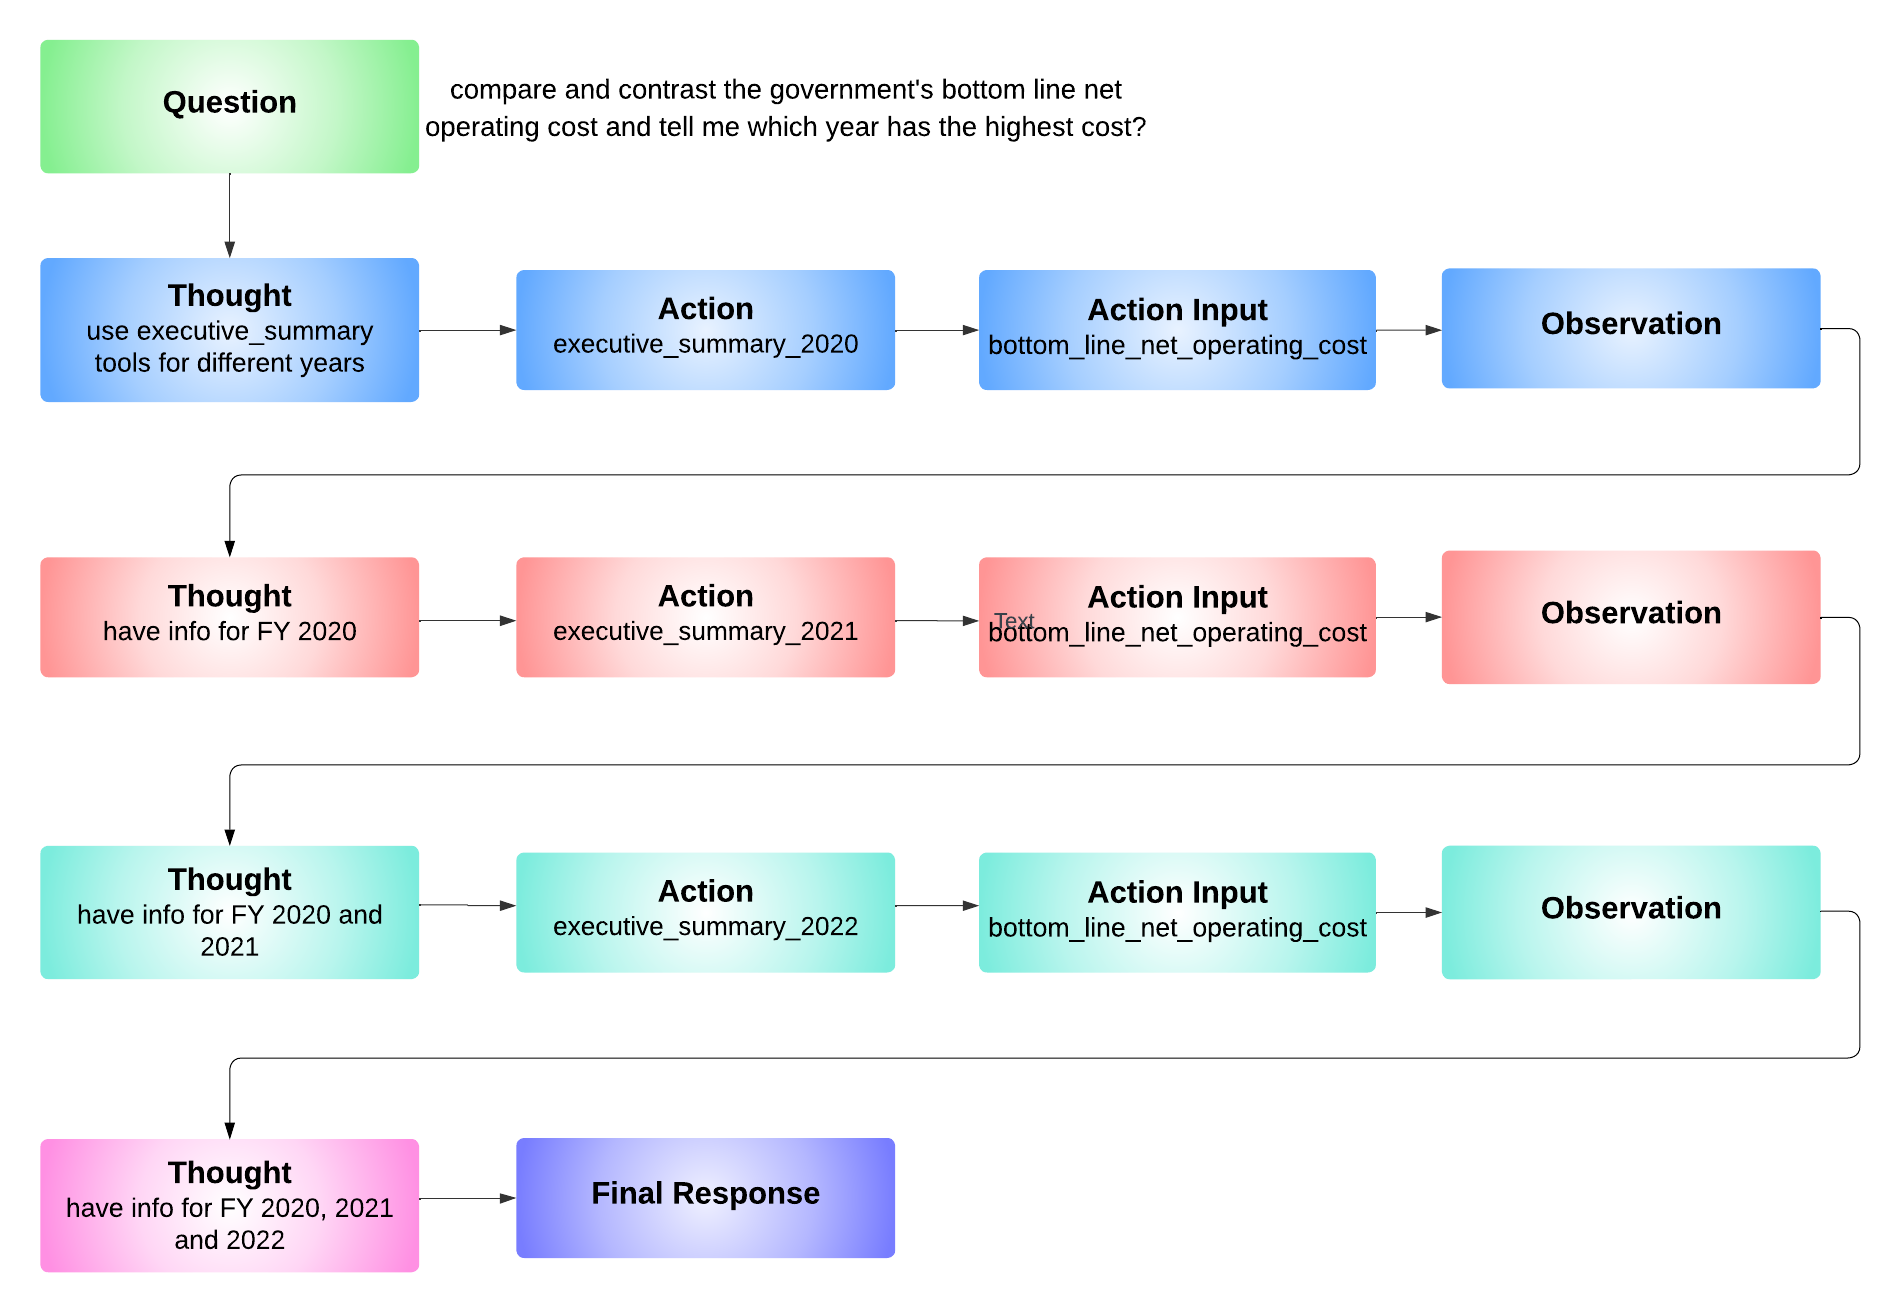

## Step 1: Install and Setup

In [1]:
!pip install -q llama_index pypdf

In [2]:
import logging, sys, os
import nest_asyncio
from google.colab import userdata

# set OpenAI API key in environment variable
os.environ["OPENAI_API_KEY"] = userdata.get("OPENAI_API_KEY")

# serves to enable nested asynchronous event loops, recommended for colab notebook
nest_asyncio.apply()

logging.basicConfig(stream=sys.stdout, level=logging.INFO)
logging.getLogger().addHandler(logging.StreamHandler(stream=sys.stdout))

Be sure to save the files with file name containing underscore, not dash, otherwise, ReAct agent chat completion won't work.

In [3]:
!mkdir reports
!wget https://www.fiscal.treasury.gov/files/reports-statements/financial-report/2020/executive-summary-2020.pdf -O ./reports/executive_summary_2020.pdf
!wget https://www.fiscal.treasury.gov/files/reports-statements/financial-report/2021/executive-summary-2021.pdf -O ./reports/executive_summary_2021.pdf
!wget https://www.fiscal.treasury.gov/files/reports-statements/financial-report/2022/executive-summary-2022.pdf -O ./reports/executive_summary_2022.pdf

mkdir: cannot create directory ‘reports’: File exists
--2024-02-16 20:58:31--  https://www.fiscal.treasury.gov/files/reports-statements/financial-report/2020/executive-summary-2020.pdf
Resolving www.fiscal.treasury.gov (www.fiscal.treasury.gov)... 166.123.218.167, 2610:108:4100:100c::8:118
Connecting to www.fiscal.treasury.gov (www.fiscal.treasury.gov)|166.123.218.167|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2323072 (2.2M) [application/pdf]
Saving to: ‘./reports/executive_summary_2020.pdf’

./reports/executive 100%[===================>]   2.21M  1.41MB/s    in 1.6s    

2024-02-16 20:58:33 (1.41 MB/s) - ‘./reports/executive_summary_2020.pdf’ saved [2323072/2323072]

--2024-02-16 20:58:33--  https://www.fiscal.treasury.gov/files/reports-statements/financial-report/2021/executive-summary-2021.pdf
Resolving www.fiscal.treasury.gov (www.fiscal.treasury.gov)... 166.123.218.167, 2610:108:4100:100c::8:118
Connecting to www.fiscal.treasury.gov (www.fiscal.treas

## Step 2: Load data, build indices, define RouterQueryEngine

In [4]:
from llama_index.core import SimpleDirectoryReader, VectorStoreIndex
from llama_index.core.tools import QueryEngineTool, ToolMetadata
from llama_index.core.agent import ReActAgent
from llama_index.llms.openai import OpenAI
import os

llm = OpenAI(model="gpt-3.5-turbo-0613")

query_engine_tools = []

for filename in os.listdir("reports"):
    if filename.endswith(".pdf"):
        file_path = os.path.join("reports", filename)

        with open(file_path, "r") as file:
            documents = SimpleDirectoryReader(input_files=[file_path]).load_data()
            print(f"Loaded {len(documents)} documents from {filename}")
            print(filename[:-4])

            index = VectorStoreIndex.from_documents(documents)
            query_engine = index.as_query_engine(similarity_top_k=5)
            query_engine_tool = QueryEngineTool(
                query_engine=query_engine,
                metadata=ToolMetadata(
                    name=f"{filename[:-4]}",  # Construct name without extension
                    description=(
                        f"Provides information about the U.S. government financial report {filename[:-4]}"
                    ),
                ),
            )
            query_engine_tools.append(query_engine_tool)

react_agent = ReActAgent.from_tools(query_engine_tools, llm=llm, verbose=True)

Loaded 11 documents from executive_summary_2020.pdf
executive_summary_2020
Loaded 10 documents from executive_summary_2022.pdf
executive_summary_2022
Loaded 11 documents from executive_summary_2021.pdf
executive_summary_2021


## Step 3: Execute Queries

In [5]:
from IPython.display import Markdown

response = react_agent.chat("Can you compare and contrast the government's bottom line net operating cost and tell me which year has the highest cost?")
display(Markdown(f"<b>{response}</b>"))

Thought: To compare and contrast the government's bottom line net operating cost, I can use the executive_summary tools for different years and compare the costs.
Action: executive_summary_2020
Action Input: {'input': 'bottom_line_net_operating_cost'}
Observation: The bottom line net operating cost refers to the total net cost incurred by the U.S. government during a specific fiscal year. It is calculated by subtracting earned program revenues and adjusting for gains or losses from changes in actuarial assumptions used to estimate future federal employee and veteran benefits payments from the total gross costs. The bottom line net operating cost for FY 2020 was $3.8 trillion, which represents an increase of $2.4 trillion (164.7 percent) compared to the previous fiscal year.
Thought: I have information about the bottom line net operating cost for FY 2020. I need to gather information about the bottom line net operating costs for other years to compare and determine which year has the hi

<b>The year with the highest bottom line net operating cost is FY 2022, with a cost of $4.2 trillion.</b>